In [ ]:
!pip install gower
!pip install imbalanced-learn xgboost scikit-learn
!pip install pyhard

In [ ]:
import pandas as pd
import itertools
import logging
import gower
import collections
import numpy as np
import sklearn.datasets
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import math
import os
import xgboost as xgb

from sklearn.model_selection import train_test_split
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.stats import iqr
from sklearn import tree
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import DistanceMetric
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from sklearn.datasets import make_blobs
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler   # For oversampling
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from pyhard.classification import ClassifiersPool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.datasets import make_blobs
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Doutorado/Pesquisa/datasets/'
PROJECT_PATH = '/content/drive/MyDrive/Doutorado/Pesquisa/'
DATASET_NAME1 = "base_std10"
DATASET_TEST1 = "base_valid_std10"
TARGET = "target"

In [ ]:
base_bst = XGBClassifier(
learning_rate=0.01,
n_estimators=1000,
max_depth=8,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective='binary:logistic',
eval_metric='logloss',
scale_pos_weight=1,
seed=27
)

colors = sns.color_palette("dark")

rosa = colors[6]

## Geração das bases artificiais

### **Base treino 2**

In [ ]:
X2, y2 = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=2,
    cluster_std=10,
    random_state=90)

In [ ]:
baseX2 = pd.DataFrame(X2, columns=['X1','X2'])
basey2 = pd.DataFrame(y2, columns=['target'])

#basey.iloc[2] = None #inserindo missing value artificialmente. Valor original da classe = 0

base2 = pd.concat([baseX2, basey2], axis=1, join="outer")
#base

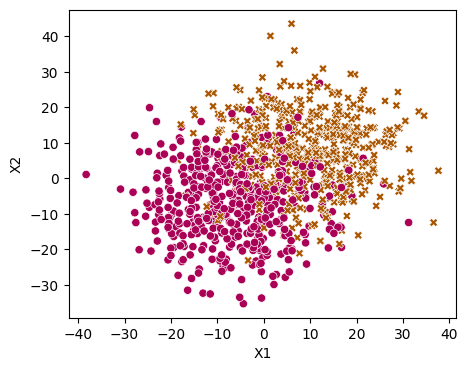

In [ ]:
fig, axes = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(5)
ax = sns.scatterplot(data=base2,
                x = "X1",
                y = "X2",
                style = "target",
                hue = "target",
                legend = "auto",
                palette = "brg")
#ax.figure.colorbar(sm, ax=ax)
ax.get_legend().remove()
plt.show()


In [ ]:
base2.to_csv(DATASET_PATH + '/base_std10.csv', sep=',', encoding='utf-8')

In [ ]:
base2.shape

(1000, 3)

In [ ]:
base

,X1,X2,target
0,9.475355,3.874327,1
1,-2.303714,11.087804,0
2,-6.855664,1.011099,0
3,-3.448484,1.797834,0
4,0.873347,-14.682504,0
...,...,...,...
995,2.748407,9.573697,1
996,14.832096,10.088129,1
997,-10.487310,-11.641653,0
998,-13.209226,-12.429093,0


### **Base teste 2**

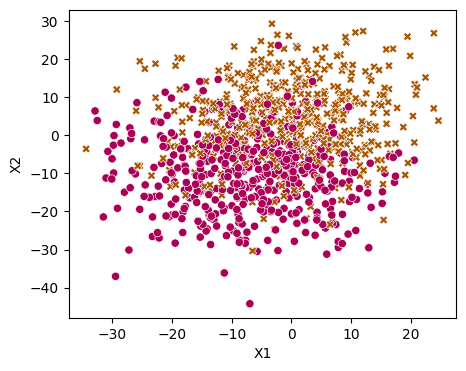

In [ ]:
X2, y2 = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=2,
    cluster_std=10,
    random_state=11)

baseX2 = pd.DataFrame(X2, columns=['X1','X2'])
basey2 = pd.DataFrame(y2, columns=['target'])

#basey.iloc[2] = None #inserindo missing value artificialmente. Valor original da classe = 0

base2 = pd.concat([baseX2, basey2], axis=1, join="outer")
#base

fig, axes = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(5)
ax = sns.scatterplot(data=base2,
                x = "X1",
                y = "X2",
                style = "target",
                hue = "target",
                legend = "auto",
                palette = "brg")
#ax.figure.colorbar(sm, ax=ax)
ax.get_legend().remove()
plt.show()

In [ ]:
base2.to_csv(DATASET_PATH + '/base_valid_std10.csv', sep=',', encoding='utf-8')



---

# **ABORDAGEM 1: metamodelo a partir das IHMs**

---

## 5 repartições de treino e validação

In [ ]:
class SamplesBuilder:
    def __init__(self, csv_path, name, splits_dir="output_splits"):
        """
        Initialize the SamplesBuilder with a CSV path and output directory.

        Parameters:
        - csv_path (str): Path to the input CSV file.
        - output_dir (str): Directory to save the generated splits.
        """
        self.csv_path = csv_path
        self.splits_dir = splits_dir
        self.data = pd.read_csv(csv_path)
        self.splits = {}  # To store train/validation splits for each seed
        self.name = name

        # Ensure the output directory exists
        os.makedirs(self.splits_dir, exist_ok=True)

    @staticmethod
    def impute_missing(train, n_neighbors=3):
        """
        Static method to impute missing values using the K-nearest neighbors algorithm.
        """
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_data = imputer.fit_transform(train)
        imputed_df = pd.DataFrame(imputed_data, columns=train.columns, index=train.index)
        return imputed_df

    def split_samples(self, seeds=[42, 43, 44, 45, 46]):
        """
        Split the data into train and validation sets using multiple seeds and save them to CSV.

        Parameters:
        - seeds (list): List of random seeds to generate splits.
        """
        for seed in seeds:
            train, val = train_test_split(self.data, test_size=0.3, random_state=seed)

            #train = self.ih_measure(train)

            self.splits[seed] = {'train': train, 'validation': val}

            # Save splits as CSV
            train_path = os.path.join(self.splits_dir, f"train_{self.name}_seed_{seed}.csv")
            val_path = os.path.join(self.splits_dir, f"validation_{self.name}_seed_{seed}.csv")

            train.to_csv(train_path, index=False)
            val.to_csv(val_path, index=False)


        print(f"Splits created and saved in '{self.splits_dir}' for seeds: {seeds}")

In [ ]:
# Instantiate the class
builder = SamplesBuilder(DATASET_PATH + DATASET_NAME1 + '.csv', DATASET_NAME1, splits_dir= PROJECT_PATH + "splits")

# Generate splits and save them
builder.split_samples()

Splits created and saved in '/content/drive/MyDrive/Doutorado/Pesquisa/splits' for seeds: [42, 43, 44, 45, 46]


## Cálculo das IHMs

In [ ]:
class Measures(ABC):
    """
    Base class for measures (aka meta-features). Each measure should be implemented as a separate method.
    """

    _measures_dict: dict

    @property
    def logger(self):
        raise NotImplementedError

    def _call_method(self, name, **kwargs):
        return getattr(self, name)(**kwargs)

    def calculate_all(self, measures_list=None):
        if measures_list is None:
            measures_list = self._measures_dict.keys()
        elif isinstance(measures_list, list):
            measures_list = sorted(list(set(measures_list) & set(self._measures_dict.keys())))
        else:
            raise TypeError(f"Expected type list for parameter 'measures_list', not '{type(measures_list)}'")

        results = collections.OrderedDict()
        for k in measures_list:
            self.logger.info(f"Calculating measure {repr(k)}")
            results[k] = self._call_method(self._measures_dict[k])

        df_measures = pd.DataFrame(results)
        return df_measures.add_prefix('feature_')

def minmax(f: np.ndarray, y: np.ndarray) -> float:
    r"""
    For binary classes, calculates :math:`\min \max (f_i) = \min ( \max (f^{c_1}_i), \max (f^{c_2}_i) )`, where
    :math:`f^{c_j}_i` is the i-th feature values for members of class :math:`c_j`.

    Args:
        f (array-like): i-th feature vector
        y (array-like): corresponding class vector

    Returns:
        float: minmax value

    Raises:
        AssertionError: If classes are not binary

    """
    classes = np.unique(y)
    assert len(classes) == 2
    c1 = classes[0]
    c2 = classes[1]
    return min(np.max(f[y == c1]), np.max(f[y == c2]))

def maxmin(f: np.ndarray, y: np.ndarray):
    r"""
    For binary classes, calculates :math:`\max \min (f_i) = \max ( \min (f^{c_1}_i), \min (f^{c_2}_i) )`, where
    :math:`f^{c_j}_i` is the i-th feature values for members of class :math:`c_j`.

    Args:
        f (array-like): i-th feature vector
        y (array-like): corresponding class vector

    Returns:
        float: maxmin value

    Raises:
        AssertionError: If classes are not binary

    """
    classes = np.unique(y)
    assert len(classes) == 2
    c1 = classes[0]
    c2 = classes[1]
    return max(np.min(f[y == c1]), np.min(f[y == c2]))

class ClassificationMeasures(Measures):
    """
    Hardness measures for classification. It provides separate methods to compute each measure.

    Args:
        data (pd.DataFrame): a dataframe where each line is an instace and columns are features. One column should
            contain the labels. The name of the column with labels can be set with parameter `labels_col`
        target_col (str): name of the column that contains the labels of the instances (default None - uses the
            last column)
        ccp_alpha (float): pruning parameter for pruned tree measures. If none is passed, then it attempts to tune
            it automatically
    """

    _measures_dict = {
        'kDNadj': 'k_disagreeing_neighbors_adjusted',
        'CLDadj': 'class_likeliood_diff_adjusted',
        'DCPadj': 'disjunct_class_percentage_adjusted',
        'DSadj': 'disjunct_size_adjusted',
        'TD_Padj': 'tree_depth_pruned_adjusted',
        'TD_Uadj': 'tree_depth_unpruned_adjusted',
#        'F1adj': 'f1_adjusted',
        'N2adj': 'intra_extra_ratio_adjusted'
    }

    logger = logging.getLogger(__name__)

    def __init__(self, data: pd.DataFrame, target_col=None, ccp_alpha=None):
        if target_col is None:
            self.target_col = data.columns[-1]
            self.y = data.iloc[:, -1]
        else:
            self.target_col = target_col
            self.y = data[target_col]
        self.data = data.reset_index(drop=True)
        self.X = data.drop(columns=self.target_col)
        self.N = len(data)

        seed = np.random.seed(55)

        # Gower distance matrix
        self.dist_matrix_gower = gower.gower_matrix(self.X.values.copy())
        #self.dist_matrix_gower = gower_distance(self.X)
        delta = np.diag(-np.ones(self.dist_matrix_gower.shape[0]))
        self.indices_gower = np.argsort(self.dist_matrix_gower + delta, axis=1)
        self.distances_gower = np.sort(self.dist_matrix_gower, axis=1)

        self.dot = None

        # Naive Bayes classifier
        n_c = self.y.nunique()
        priors = np.ones((n_c,)) / n_c

        nb = GaussianNB()#priors=priors
        self.calibrated_nb = CalibratedClassifierCV(
            estimator=nb,
            method='sigmoid',
            cv=3,
            ensemble=False,
            n_jobs=-1
        )
        self.calibrated_nb.fit(self.X, self.y)

###################################################################################################################################


    def k_disagreeing_neighbors_adjusted(self, k: int = 10, distance: str = 'gower') -> np.ndarray:
        r"""
        k-Disagreeing Neighbors Adjusted (kDNadj) gives the percentage of the :math:`k` nearest neighbors of :math:`\\mathbf x_i`
        which do not share its label.

        .. math::

            kDNadj(\mathbf{x_i}) = \frac{ \sharp \{\mathbf x_j | \mathbf x_j \in kNN(\mathbf x_i) \wedge y_j
            \neq y_i\}}{k}

        Args:
            k (int): number of neighbors
            distance (str): distance metric (default 'gower')

        Returns:
            array-like: :math:`kDNadj(\mathbf x_i)`
        """
        data = self.data.copy()
        if distance == 'gower':
            indices = self.indices_gower[:, :k + 1]
        else:
            nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(self.X)
            distances, indices = nbrs.kneighbors(self.X)

        unique_values = pd.unique(data[self.target_col])
        C = [[] for _ in unique_values]
        vl_unico = sorted(unique_values.tolist())

        for j in vl_unico:
          for i in range(0, len(data)):
              v = data.loc[indices[i]][self.target_col].values
              #v[i] = None
              C[j].append(np.sum(v[1:] == vl_unico[j]) / k)

        kDNadj = []
        for i in range(len(C[0])):
          entropy = 0.0
          p = [c[i] for c in C]
          entropy -= sum(p * math.log2(p) if p > 0 else 0 for p in p)
          kDNadj.append(entropy)

        return kDNadj

###################################################################################################################################

    def intra_extra_ratio_adjusted(self, distance='gower') -> np.ndarray:
        r"""
        Ratio of the intra-class and extra-class distances (N2): first the ratio of the distance of :math:`\mathbf x_i`
        to the nearest example from its class to the distance it has to the nearest instance from a different class
        (aka nearest enemy) is computed:

        .. math::

            IntraInter(\mathbf x_i) = \frac{d(\mathbf x_i,NN(\mathbf x_i) \in y_i)}{d(\mathbf x_i, ne(\mathbf x_i))}

        where :math:`NN(\mathbf x_i)` represents a nearest neighbor of :math:`\mathbf x_i` and :math:`ne(\mathbf x_i)`
        is the nearest enemy of :math:`\mathbf x_i`:

        .. math::

            ne(\mathbf x_i) = NN(\mathbf x_i) \in y_j \neq y_i

        Then :math:`N_2` is taken as:

        .. math::

            N_2(\mathbf x_i) = 1 - \frac{1}{IntraInter(\mathbf x_i) + 1}

        Larger values of :math:`N2(\mathbf x_i)` indicate that the instance :math:`\mathbf x_i` is closer to an example
        from another class than to an example from its own class and is, therefore, harder to classify.

        Args:
            distance (str): the distance metric to use (default `'gower'`). See `this link
                <https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
                #sklearn.neighbors.DistanceMetric>`_ for a list of available metrics.

        Returns:
            array-like: :math:`N_2(\mathbf x_i)`
        """
        y = self.y.copy()

        if distance == 'gower':
            indices = self.indices_gower
            distances = self.distances_gower
        else:
            nbrs = NearestNeighbors(n_neighbors=len(self.y), algorithm='auto', metric=distance).fit(self.X)
            distances, indices = nbrs.kneighbors(self.X)

        N2 = np.zeros(y.values.shape)
        for i, label in y.items():
            nn = y.loc[indices[i, :]]
            nn1 = nn.iloc[1]
            intra = nn.eq(nn)
            extra = nn.ne(nn1)
            assert np.all(np.diff(distances[i, intra]) >= 0)
            assert np.all(np.diff(distances[i, extra]) >= 0)
            N2[i] = distances[i, intra][1] / max(distances[i, extra][1], 1e-15)
        return N2

###################################################################################################################################

    def class_likeliood_diff_adjusted(self) -> np.ndarray:
        r"""
        Class Likelihood Difference (CLD) takes the difference between the likelihood of :math:`\mathbf x_i` in
        relation to its class and the maximum likelihood it has to any other class.

        .. math::

            CLD(\mathbf x_i) = \frac{1 -\left (P(\mathbf x_i|y_i)P(y_i) - \max_{y_j \neq y_i}
            [P(\mathbf x_i |y_j)P(y_j)]\right )}{2}

        The difference in the class likelihood is larger for easier instances, because the confidence it belongs to its
        class is larger than that of any other class. We take the complement of the measure as indicated in the
        equation above.

        Returns:
            array-like: :math:`CLD(\mathbf x_i)`
        """
        data = self.data.copy()
        proba = self.calibrated_nb.predict_proba(self.X)
        array_of_lists = np.array(proba)

        max_indices = np.argsort(array_of_lists, axis=1)[:, -2:]
        largest_values = array_of_lists[np.arange(array_of_lists.shape[0])[:, None], max_indices]
        subtraction_result = (largest_values[:, 0] - largest_values[:, 1]) * (-1)

        resultados = subtraction_result.reshape(-1)

        return (1 - np.array(resultados)) / 2

###################################################################################################################################

    def disjunct_class_percentage_adjusted(self,target_col=None,ccp_alpha=None) -> np.ndarray:
        r"""
        Disjunct Class Percentage (DCP) builds a decision tree using :math:`\mathcal{D}` and considers the percentage
        of instances in the disjunct of :math:`\mathbf x_i` which share the same label as :math:`\mathbf x_i`.
        The disjunct of an example corresponds to the leaf node where it is classified by the decision tree.

        .. math::

            DCP(\mathbf x_i) = 1- \frac{\sharp\{\mathbf x_j | \mathbf x_j \in Disjunct(\mathbf x_i) \wedge y_j = y_i\}}
            {\sharp\{\mathbf x_j|\mathbf x_j \in Disjunct(\mathbf x_i)\}}

        Returns:
            array-like: :math:`DCP(\mathbf x_i)`
        """
        data = self.data.copy()
        seed = np.random.seed(55)

          #rodar a metodologia do HM com a estimativa do y
          #Decision Tree Classifier Pruned
        df_dcp = data.copy()
        if target_col is None:
          target_col = df_dcp.columns[-1]
          y = df_dcp.iloc[:, -1]
        else:
          target_col = target_col
          y = df_dcp[target_col]
        df_dcp = df_dcp.reset_index(drop=True)
        X = df_dcp.drop(columns=target_col)

        if ccp_alpha is None:
            parameters = {'ccp_alpha': np.linspace(0.001, 0.1, num=100)}
            dtc = tree.DecisionTreeClassifier(criterion='gini', random_state=seed)
            clf = GridSearchCV(dtc, parameters, n_jobs=-1)
            clf.fit(X.values, y.values)
            ccp_alpha = clf.best_params_['ccp_alpha']

        dtc_pruned = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=ccp_alpha, random_state=seed)
        dtc_pruned = dtc_pruned.fit(X.values, y.values)

        df_dcp['leaf_id'] = dtc_pruned.apply(X.values)

        unique_values = pd.unique(y)
        C = [[] for _ in unique_values]
        vl_unico = sorted(unique_values.tolist())

        for j in vl_unico:
            for index, row in df_dcp.iterrows():
              df_leaf = df_dcp[df_dcp['leaf_id'] == row['leaf_id']]
              if row[TARGET] == vl_unico[j]:
                C[j].append(len(df_leaf[df_leaf[TARGET] == row[TARGET]]) / len(df_leaf))
              else:
                C[j].append(len(df_leaf[df_leaf[TARGET] == vl_unico[j]]) / len(df_leaf))

        DCPadj = []
        for n in range(len(C[0])):
          entropy = 0.0
          p = [c[n] for c in C]
          entropy -= sum(p * math.log2(p) if p > 0 else 0 for p in p)
          DCPadj.append(entropy)
        return DCPadj


###################################################################################################################################

    def disjunct_size_adjusted(self,target_col=None) -> np.ndarray:

        data = self.data.copy()
        seed = np.random.seed(55)

        df_ds = data.copy()
        train_sample = data.drop(data.index[-1])

          #rodar a metodologia do HM com a estimativa do y
          #Decision Tree Classifier
        if target_col is None:
          target_col = df_ds.columns[-1]
          y = df_ds.iloc[:, -1]
        else:
          target_col = target_col
          y = df_ds[target_col]
        df_ds = df_ds.reset_index(drop=True)
        X = df_ds.drop(columns=target_col)

        dtc = tree.DecisionTreeClassifier(min_samples_split=2, criterion='gini', random_state=seed)
        dtc = dtc.fit(X.values, y.values)

        df_ds['leaf_id'] = dtc.apply(X.values)
        df_count = df_ds.groupby('leaf_id').count().iloc[:, 0].to_frame('count').subtract(1) #iloc referencia a posição da linha/coluna. loc retorna o label da linha/coluna
          #aqui, iloc fixando primeira coluna, varrendo todas as linhas
        df_ds = df_ds.join(df_count, on='leaf_id')
        DSadj = df_ds['count'].divide(df_ds['count'].max())
          #pd.set_option('display.max_rows', data.shape[0]+1)
          #print(data)

        return 1 - DSadj.values

###################################################################################################################################


    def tree_depth_unpruned_adjusted(self,target_col=None) -> np.ndarray:
        r"""
        Tree Depth (TD) returns the depth of the leaf node that classifies :math:`\mathbf x_i` in a  decision tree,
        normalized by the maximum depth of the tree built from :math:`D`:

        .. math::

            TD(\mathbf x_i) = \frac{depth(\mathbf x_i)}{\max(depth(D))}

        There are two versions of this measure, using pruned (:math:`TD_P(\mathbf x_i)`)
        and unpruned (:math:`TD_U(\mathbf x_i)`) decision trees. Instances harder to classify tend to be placed
        at deeper levels of the trees and present higher :math:`TD` values.

        Returns:
            array-like: :math:`TD_U(\mathbf x_i)`
        """
        data = self.data.copy()
        seed = np.random.seed(55)

        df_ds = data.copy()
        train_sample = data.drop(data.index[-1])

          #rodar a metodologia do HM com a estimativa do y
          #Decision Tree Classifier
        if target_col is None:
          target_col = df_ds.columns[-1]
          y = df_ds.iloc[:, -1]
        else:
          target_col = target_col
          y = df_ds[target_col]
        df_ds = df_ds.reset_index(drop=True)
        X = df_ds.drop(columns=target_col)

        dtc = tree.DecisionTreeClassifier(min_samples_split=2, criterion='gini', random_state=seed)
        dtc = dtc.fit(X.values, y.values)

        TDUadj = X.apply(lambda x: dtc.decision_path([x]).sum() - 1, axis=1, raw=True).values / dtc.get_depth()

        return TDUadj

###################################################################################################################################

    def tree_depth_pruned_adjusted(self,target_col=None,ccp_alpha=None) -> np.ndarray:
        r"""
        Tree Depth (TD) returns the depth of the leaf node that classifies :math:`\mathbf x_i` in a  decision tree,
        normalized by the maximum depth of the tree built from :math:`D`:

        .. math::

            TD(\mathbf x_i) = \frac{depth(\mathbf x_i)}{\max(depth(D))}

        There are two versions of this measure, using pruned (:math:`TD_P(\mathbf x_i)`)
        and unpruned (:math:`TD_U(\mathbf x_i)`) decision trees. Instances harder to classify tend to be placed
        at deeper levels of the trees and present higher :math:`TD` values.

        Returns:
            array-like: :math:`TD_P(\mathbf x_i)`
        """

        data = self.data.copy()
        seed = np.random.seed(55)

        df_dcp = data.copy()
        train_sample = data.drop(data.index[-1])

          #rodar a metodologia do HM com a estimativa do y
          #Decision Tree Classifier Pruned
        if target_col is None:
          target_col = df_dcp.columns[-1]
          y = df_dcp.iloc[:, -1]
        else:
          target_col = target_col
          y = df_dcp[target_col]
        df_dcp = df_dcp.reset_index(drop=True)
        X = df_dcp.drop(columns=target_col)

        if ccp_alpha is None:
            parameters = {'ccp_alpha': np.linspace(0.001, 0.1, num=100)}
            dtc = tree.DecisionTreeClassifier(criterion='gini', random_state=seed)
            clf = GridSearchCV(dtc, parameters, n_jobs=-1)
            clf.fit(X.values, y.values)
            ccp_alpha = clf.best_params_['ccp_alpha']

        dtc_pruned = tree.DecisionTreeClassifier(criterion='gini', ccp_alpha=ccp_alpha, random_state=seed)
        dtc_pruned = dtc_pruned.fit(X.values, y.values)

        TDPadj = X.apply(lambda x: dtc_pruned.decision_path([x]).sum() - 1, axis=1, raw=True).values / dtc_pruned.get_depth()

        return TDPadj


## Aplicação nos conjuntos de treino

In [ ]:
df_hm_seed = []
for seed, splits in builder.splits.items():
    #modified_train_sets = []
    validation_data = splits['validation']
    for index, row in validation_data.iterrows():
        current_train = splits['train'].copy()
        current_train = pd.concat([current_train, pd.DataFrame([row])], ignore_index=True)
        #modified_train_sets.append(current_train)

        # Separate numerical features for KNN imputation
        numerical_features = current_train.select_dtypes(include=np.number).columns.tolist()
        modified_train_set_numerical = current_train[numerical_features]

        # Apply KNN imputation to the numerical features
        imputed_modified_train_set = SamplesBuilder.impute_missing(modified_train_set_numerical)

        # Replace the original numerical columns with the imputed ones
        current_train[numerical_features] = imputed_modified_train_set
        current_train[TARGET] = current_train[TARGET].astype(int)

        m = ClassificationMeasures(current_train)
        df_meta_feat = m.calculate_all()
        df_hm = pd.DataFrame(df_meta_feat, columns=['feature_kDNadj','feature_N2adj','feature_CLDadj','feature_DCPadj','feature_DSadj','feature_TD_Uadj','feature_TD_Padj'])

        # Get the last row of the current df_hm
        last_row = df_hm.tail(1).copy()

        # Add a column to identify the seed
        last_row['seed'] = seed

        # Append the last row to the list of DataFrames to stack
        df_hm_seed.append(last_row)

# Concatenate all the DataFrames in the list into a single DataFrame
df_hm_final = pd.concat(df_hm_seed, ignore_index=True)

# Now you have 'stacked_df' which contains the last row of each df_hm with seed information.
print(df_hm_final.head())

df_hm_final.to_csv(PROJECT_PATH + 'df_hm_' + DATASET_NAME1 + '.csv', sep=',', encoding='utf-8')

A saída de streaming foi truncada nas últimas 5000 linhas.
INFO:__main__:Calculating measure 'TD_Uadj'
INFO:__main__:Calculating measure 'N2adj'
INFO:__main__:Calculating measure 'kDNadj'
INFO:__main__:Calculating measure 'CLDadj'
INFO:__main__:Calculating measure 'DCPadj'
INFO:__main__:Calculating measure 'DSadj'
INFO:__main__:Calculating measure 'TD_Padj'
INFO:__main__:Calculating measure 'TD_Uadj'
INFO:__main__:Calculating measure 'N2adj'
INFO:__main__:Calculating measure 'kDNadj'
INFO:__main__:Calculating measure 'CLDadj'
INFO:__main__:Calculating measure 'DCPadj'
INFO:__main__:Calculating measure 'DSadj'
INFO:__main__:Calculating measure 'TD_Padj'
INFO:__main__:Calculating measure 'TD_Uadj'
INFO:__main__:Calculating measure 'N2adj'
INFO:__main__:Calculating measure 'kDNadj'
INFO:__main__:Calculating measure 'CLDadj'
INFO:__main__:Calculating measure 'DCPadj'
INFO:__main__:Calculating measure 'DSadj'
INFO:__main__:Calculating measure 'TD_Padj'
INFO:__main__:Calculating measure 'TD_

   feature_kDNadj  feature_N2adj  feature_CLDadj  feature_DCPadj  \
0        0.000000       0.108806        0.064433        0.530513   
1        0.970951       0.885549        0.107612        0.453128   
2        0.970951       0.354218        0.145310        0.953317   
3        0.468996       0.304283        0.123602        0.669016   
4        0.000000       0.311616        0.065944        0.440644   

   feature_DSadj  feature_TD_Uadj  feature_TD_Padj  seed  
0       0.553571         0.666667         0.800000    42  
1       1.000000         0.733333         0.666667    42  
2       0.928571         0.466667         1.000000    42  
3       0.821429         0.466667         0.666667    42  
4       0.625000         0.466667         0.666667    42  


## Estima classes para base de metafeatures via XGBoost

In [ ]:
class ResultsGenerator:
    def __init__(self, name, splits_dir= PROJECT_PATH + "output_splits", results_dir= PROJECT_PATH + "output_results"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
        self.splits_dir = splits_dir
        self.results_dir = results_dir
        self.name = name

        # Ensure the output directory exists
        os.makedirs(self.results_dir, exist_ok=True)

    @staticmethod
    def data_sample(X, y):

        # Define sampling strategies
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        oversample = RandomOverSampler(sampling_strategy=0.2, random_state=1)

        # Identify the minority class
        count_1 = (y == 1).sum()
        count_0 = (y == 0).sum()
        count_min = min(count_0, count_1)
        count_max = max(count_0, count_1)

        # Calculate the percentage of the minority class compared to the total number of instances
        ratio = (count_min / count_max)

        # If the minority class is more than 60% of the majority class, do not apply any resampling technique
        if ratio > 0.6:
            return X, y

        # Check if the percentage of class 1 is at least 5% of the total number of instances
        # If it is less than 5%, apply both over and under sampling
        elif ratio <= 0.2:
            X, y = oversample.fit_resample(X, y)
            return undersample.fit_resample(X, y)

        else:
            return undersample.fit_resample(X, y)

    def get_results(self):
        for seed in [42, 43, 44, 45, 46]:

                data_train = pd.read_csv(f'{self.splits_dir}/train_{self.name}_seed_{seed}.csv')
                data_test = pd.read_csv(f'{self.splits_dir}/validation_{self.name}_seed_{seed}.csv')

                target_feature = data_train.columns[-1]

                # Split X and y
                X_train = data_train.drop(columns=[target_feature])
                y_train = data_train[target_feature]
                X_test = data_test.drop(columns=[target_feature])
                y_test = data_test[target_feature]

                # Resample
                X_resampled, y_resampled = ResultsGenerator.data_sample(X_train, y_train)

                bst = CalibratedClassifierCV(estimator=base_bst, method='sigmoid', cv=5, ensemble=False, n_jobs=None )

                # Fit model
                bst.fit(X_resampled, y_resampled)

                y_pred_proba = bst.predict_proba(X_test)
                y_pred_positive = y_pred_proba[:, 1]  # Predicted probabilities for positive class
                y_pred_negative = y_pred_proba[:, 0]  # Predicted probabilities for negative class

                # Determine which class is predicted for each instance
                predicted_class = np.argmax(y_pred_proba, axis=1)  # Predicted class (0 for negative, 1 for positive)

                # Combine positive and negative confidence scores based on predicted class
                confidence_scores = np.where(predicted_class == 1, y_pred_positive, y_pred_negative)

                # Create DataFrame with true labels, predicted probabilities, and confidence scores
                results = pd.DataFrame({'True_Labels': y_test,
                                        'Predicted_Class': predicted_class,
                                        'Confidence_Scores': confidence_scores})

                results.to_csv(f'{self.results_dir}/results_seed_{seed}_{self.name}.csv')

In [ ]:
# Instantiate the class
results = ResultsGenerator(DATASET_NAME1, splits_dir = PROJECT_PATH + "splits", results_dir= PROJECT_PATH + "results_"+DATASET_NAME1)

# Generate splits and save them
results.get_results()

## Criação do metamodelo nas bases de validação empilhadas

In [ ]:
def stack_results(results_dir, name):
    """Stacks the results from multiple CSV files into a single DataFrame.

    Args:
        results_dir (str): The directory containing the CSV files.
        name (str): The name used in the CSV filenames (e.g. 'hsl').

    Returns:
        pandas.DataFrame: A DataFrame containing the stacked results,
                          or None if no matching files are found.
    """

    all_results = []
    for seed in [42, 43, 44, 45, 46]:
        file_path = f'{results_dir}/results_seed_{seed}_{name}.csv'
        try:
            results_df = pd.read_csv(file_path)
            results_df['seed'] = seed #add seed column for identification
            all_results.append(results_df)
        except FileNotFoundError:
            print(f"Warning: File not found - {file_path}")
            return None  # Return None if any file is not found

    if all_results:
      stacked_results = pd.concat(all_results, ignore_index=True)
      return stacked_results
    else:
      return None


# Example usage (assuming 'results' object is defined as in your code):
stacked_df = stack_results(PROJECT_PATH + "results_" + DATASET_NAME1, DATASET_NAME1)

if stacked_df is not None:
  print(stacked_df.head())
  # Proceed with using the stacked_df
else:
  print("No results files found or error encountered.")

   Unnamed: 0  True_Labels  Predicted_Class  Confidence_Scores  seed
0           0            0                0           0.861281    42
1           1            0                1           0.622953    42
2           2            0                0           0.874350    42
3           3            1                1           0.894705    42
4           4            1                1           0.882445    42


In [ ]:
# Convert 'True_Labels' and 'Predicted_Class' to numeric if they're not already
stacked_df['True_Labels'] = pd.to_numeric(stacked_df['True_Labels'], errors='coerce')
stacked_df['Predicted_Class'] = pd.to_numeric(stacked_df['Predicted_Class'], errors='coerce')


# Create the 'Acerto' column based on the comparison
stacked_df['Acerto'] = np.where(stacked_df['True_Labels'] == stacked_df['Predicted_Class'], 1, 0)

print(stacked_df.head())

   Unnamed: 0  True_Labels  Predicted_Class  Confidence_Scores  seed  Acerto
0           0            0                0           0.861281    42       1
1           1            0                1           0.622953    42       0
2           2            0                0           0.874350    42       1
3           3            1                1           0.894705    42       1
4           4            1                1           0.882445    42       1


In [ ]:
stacked_df.shape

(1500, 6)

In [ ]:
df_hm_valid = pd.read_csv(PROJECT_PATH + 'df_hm_' + DATASET_NAME1 + '.csv',sep=',',encoding='utf-8')
df_hm_valid['acerto'] = stacked_df['Acerto'].values
df_hm_valid = df_hm_valid.drop(columns=['Unnamed: 0'])
df_hm_valid

,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj,seed,acerto
0,0.000000,0.108806,0.064433,0.530513,0.553571,0.666667,0.800000,42,1
1,0.970951,0.885549,0.107612,0.453128,1.000000,0.733333,0.666667,42,0
2,0.970951,0.354218,0.145310,0.953317,0.928571,0.466667,1.000000,42,1
3,0.468996,0.304283,0.123602,0.669016,0.821429,0.466667,0.666667,42,1
4,0.000000,0.311616,0.065944,0.440644,0.625000,0.466667,0.666667,42,1
...,...,...,...,...,...,...,...,...,...
1495,0.721928,0.486003,0.076685,0.380947,0.735632,0.411765,0.500000,46,1
1496,0.000000,0.318421,0.052003,0.380947,0.632184,0.411765,0.666667,46,1
1497,0.881291,0.655420,0.131887,0.447802,0.839080,0.411765,0.500000,46,1
1498,0.468996,0.938055,0.072997,0.447802,0.632184,0.294118,0.666667,46,1


### Modelagem do metamodelo a partir das IHMs

In [ ]:
# Assuming df_merged is your dataframe and 'Predicted_Class' is the target variable
X = df_hm_valid.drop('acerto', axis=1)
y = df_hm_valid['acerto']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Set random_state for reproducibility

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=90)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para AUC

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    auc_scores.append(auc)

    # Impressão por fold
    print(f"\n🔁 Fold {fold}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

# Médias ao final
print("\n📊 MÉDIAS DAS MÉTRICAS:")
print(f"Average Accuracy:  {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall:    {np.mean(recall_scores):.4f}")
print(f"Average F1-score:  {np.mean(f1_scores):.4f}")
print(f"Average AUC:       {np.mean(auc_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 1
Accuracy:  0.8933
Precision: 0.9237
Recall:    0.9397
F1-score:  0.9316
AUC:       0.9455
Confusion Matrix:
[[ 25   9]
 [  7 109]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7812    0.7353    0.7576        34
           1     0.9237    0.9397    0.9316       116

    accuracy                         0.8933       150
   macro avg     0.8525    0.8375    0.8446       150
weighted avg     0.8914    0.8933    0.8922       150


🔁 Fold 2
Accuracy:  0.8600
Precision: 0.9397
Recall:    0.8862
F1-score:  0.9121
AUC:       0.8877
Confusion Matrix:
[[ 20   7]
 [ 14 109]]
Classification Report:
              precision    recall  f1-score   support

           0     0.5882    0.7407    0.6557        27
           1     0.9397    0.8862    0.9121       123

    accuracy                         0.8600       150
   macro avg     0.7639    0.8135    0.7839       150
weighted avg     0.8764    0.8600    0.8660       150


🔁 Fold 3
Accuracy

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 4
Accuracy:  0.8933
Precision: 0.9180
Recall:    0.9492
F1-score:  0.9333
AUC:       0.9611
Confusion Matrix:
[[ 22  10]
 [  6 112]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7857    0.6875    0.7333        32
           1     0.9180    0.9492    0.9333       118

    accuracy                         0.8933       150
   macro avg     0.8519    0.8183    0.8333       150
weighted avg     0.8898    0.8933    0.8907       150


🔁 Fold 5
Accuracy:  0.9200
Precision: 0.9291
Recall:    0.9752
F1-score:  0.9516
AUC:       0.9624
Confusion Matrix:
[[ 20   9]
 [  3 118]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8696    0.6897    0.7692        29
           1     0.9291    0.9752    0.9516       121

    accuracy                         0.9200       150
   macro avg     0.8993    0.8324    0.8604       150
weighted avg     0.9176    0.9200    0.9164       150



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 6
Accuracy:  0.8933
Precision: 0.9313
Recall:    0.9457
F1-score:  0.9385
AUC:       0.9531
Confusion Matrix:
[[ 12   9]
 [  7 122]]
Classification Report:
              precision    recall  f1-score   support

           0     0.6316    0.5714    0.6000        21
           1     0.9313    0.9457    0.9385       129

    accuracy                         0.8933       150
   macro avg     0.7814    0.7586    0.7692       150
weighted avg     0.8893    0.8933    0.8911       150


🔁 Fold 7
Accuracy:  0.8933
Precision: 0.9313
Recall:    0.9457
F1-score:  0.9385
AUC:       0.9428
Confusion Matrix:
[[ 12   9]
 [  7 122]]
Classification Report:
              precision    recall  f1-score   support

           0     0.6316    0.5714    0.6000        21
           1     0.9313    0.9457    0.9385       129

    accuracy                         0.8933       150
   macro avg     0.7814    0.7586    0.7692       150
weighted avg     0.8893    0.8933    0.8911       150



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 8
Accuracy:  0.8467
Precision: 0.9016
Recall:    0.9091
F1-score:  0.9053
AUC:       0.9248
Confusion Matrix:
[[ 17  12]
 [ 11 110]]
Classification Report:
              precision    recall  f1-score   support

           0     0.6071    0.5862    0.5965        29
           1     0.9016    0.9091    0.9053       121

    accuracy                         0.8467       150
   macro avg     0.7544    0.7476    0.7509       150
weighted avg     0.8447    0.8467    0.8456       150


🔁 Fold 9
Accuracy:  0.8800
Precision: 0.9008
Recall:    0.9478
F1-score:  0.9237
AUC:       0.9366
Confusion Matrix:
[[ 23  12]
 [  6 109]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7931    0.6571    0.7188        35
           1     0.9008    0.9478    0.9237       115

    accuracy                         0.8800       150
   macro avg     0.8470    0.8025    0.8212       150
weighted avg     0.8757    0.8800    0.8759       150



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 10
Accuracy:  0.8667
Precision: 0.9134
Recall:    0.9280
F1-score:  0.9206
AUC:       0.9165
Confusion Matrix:
[[ 14  11]
 [  9 116]]
Classification Report:
              precision    recall  f1-score   support

           0     0.6087    0.5600    0.5833        25
           1     0.9134    0.9280    0.9206       125

    accuracy                         0.8667       150
   macro avg     0.7610    0.7440    0.7520       150
weighted avg     0.8626    0.8667    0.8644       150


📊 MÉDIAS DAS MÉTRICAS:
Average Accuracy:  0.8887
Average Precision: 0.9265
Average Recall:    0.9379
Average F1-score:  0.9319
Average AUC:       0.9394


## Treinar o meta modelo com toda a base HSL e aplicar em HBP para avaliar a performance

Usando a base com todas as IHMs pele melhor desempenho

In [ ]:
df_test = pd.read_csv(DATASET_PATH + DATASET_TEST1 + '.csv',sep=',',encoding='utf-8')
df_train = pd.read_csv(DATASET_PATH + DATASET_NAME1 + '.csv',sep=',',encoding='utf-8')

In [ ]:
m = ClassificationMeasures(df_train)
df_meta_feat = m.calculate_all()
#df_hm = pd.DataFrame(df_meta_feat, columns=['feature_N2adj'])
df_hm_train = pd.DataFrame(df_meta_feat, columns=['feature_kDNadj','feature_N2adj','feature_CLDadj','feature_DCPadj','feature_DSadj','feature_TD_Uadj','feature_TD_Padj'])
df_hm_train.head()

INFO:__main__:Calculating measure 'kDNadj'
INFO:__main__:Calculating measure 'CLDadj'
INFO:__main__:Calculating measure 'DCPadj'
INFO:__main__:Calculating measure 'DSadj'
INFO:__main__:Calculating measure 'TD_Padj'
INFO:__main__:Calculating measure 'TD_Uadj'
INFO:__main__:Calculating measure 'N2adj'


,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj
0,0.721928,0.756999,0.179488,0.445407,0.855670,0.3750,0.50
1,0.881291,0.457720,0.081645,0.800959,0.979381,0.3125,0.75
2,0.721928,0.617351,0.329275,0.970951,0.907216,0.5625,1.00
3,0.721928,0.948686,0.339186,0.970951,0.907216,0.5625,1.00
4,0.881291,0.625223,0.099836,0.967788,1.000000,0.4375,0.75


In [ ]:
df_hm_seed = []
for index, row in df_test.iterrows():
        current_train = df_train.copy()
        current_train = pd.concat([current_train, pd.DataFrame([row])], ignore_index=True)
        #modified_train_sets.append(current_train)

        # Separate numerical features for KNN imputation
        numerical_features = current_train.select_dtypes(include=np.number).columns.tolist()
        modified_train_set_numerical = current_train[numerical_features]

        # Apply KNN imputation to the numerical features
        imputed_modified_train_set = SamplesBuilder.impute_missing(modified_train_set_numerical)

        # Replace the original numerical columns with the imputed ones
        current_train[numerical_features] = imputed_modified_train_set
        current_train[TARGET] = current_train[TARGET].astype(int)

        m = ClassificationMeasures(current_train)
        df_meta_feat = m.calculate_all()
        df_hm = pd.DataFrame(df_meta_feat, columns=['feature_kDNadj','feature_N2adj','feature_CLDadj','feature_DCPadj','feature_DSadj','feature_TD_Uadj','feature_TD_Padj'])

        # Get the last row of the current df_hm
        last_row = df_hm.tail(1).copy()

        # Append the last row to the list of DataFrames to stack
        df_hm_seed.append(last_row)

# Concatenate all the DataFrames in the list into a single DataFrame
df_hm_test = pd.concat(df_hm_seed, ignore_index=True)

# Now you have 'stacked_df' which contains the last row of each df_hm with seed information.
print(df_hm_test.head())

A saída de streaming foi truncada nas últimas 5000 linhas.
INFO:__main__:Calculating measure 'TD_Uadj'
INFO:__main__:Calculating measure 'N2adj'
INFO:__main__:Calculating measure 'kDNadj'
INFO:__main__:Calculating measure 'CLDadj'
INFO:__main__:Calculating measure 'DCPadj'
INFO:__main__:Calculating measure 'DSadj'
INFO:__main__:Calculating measure 'TD_Padj'
INFO:__main__:Calculating measure 'TD_Uadj'
INFO:__main__:Calculating measure 'N2adj'
INFO:__main__:Calculating measure 'kDNadj'
INFO:__main__:Calculating measure 'CLDadj'
INFO:__main__:Calculating measure 'DCPadj'
INFO:__main__:Calculating measure 'DSadj'
INFO:__main__:Calculating measure 'TD_Padj'
INFO:__main__:Calculating measure 'TD_Uadj'
INFO:__main__:Calculating measure 'N2adj'
INFO:__main__:Calculating measure 'kDNadj'
INFO:__main__:Calculating measure 'CLDadj'
INFO:__main__:Calculating measure 'DCPadj'
INFO:__main__:Calculating measure 'DSadj'
INFO:__main__:Calculating measure 'TD_Padj'
INFO:__main__:Calculating measure 'TD_

   feature_kDNadj  feature_N2adj  feature_CLDadj  feature_DCPadj  \
0        0.881291       0.494313        0.117870        0.437017   
1        0.468996       0.664523        0.061870        0.247294   
2        0.721928       0.731730        0.075385        0.437017   
3        0.721928       0.463518        0.191058        0.247294   
4        0.000000       0.237325        0.063551        0.444552   

   feature_DSadj  feature_TD_Uadj  feature_TD_Padj  
0       0.948454           0.6875         0.571429  
1       1.000000           0.2500         0.750000  
2       0.948454           0.6875         0.571429  
3       1.000000           0.2500         0.750000  
4       0.175258           0.2500         0.500000  


In [ ]:
df_hm_test.to_csv(PROJECT_PATH + 'df_hm_' + DATASET_TEST1 + '.csv', sep=',', encoding='utf-8')
df_hm_test

,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj
0,0.881291,0.494313,0.117870,0.437017,0.948454,0.687500,0.571429
1,0.468996,0.664523,0.061870,0.247294,1.000000,0.250000,0.750000
2,0.721928,0.731730,0.075385,0.437017,0.948454,0.687500,0.571429
3,0.721928,0.463518,0.191058,0.247294,1.000000,0.250000,0.750000
4,0.000000,0.237325,0.063551,0.444552,0.175258,0.250000,0.500000
...,...,...,...,...,...,...,...
995,0.468996,0.450900,0.079444,0.627430,0.680412,0.642857,0.800000
996,0.970951,0.958922,0.456978,0.967559,0.989691,0.500000,1.000000
997,0.000000,0.117986,0.063348,0.226148,0.752577,0.500000,0.428571
998,0.000000,0.360336,0.083813,0.226148,0.752577,0.500000,0.428571


In [ ]:
df_hm_test = df_hm_test.drop(columns=['Unnamed: 0'])
df_hm_test.head()

,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj
0,0.881291,0.494313,0.117870,0.437017,0.948454,0.6875,0.571429
1,0.468996,0.664523,0.061870,0.247294,1.000000,0.2500,0.750000
2,0.721928,0.731730,0.075385,0.437017,0.948454,0.6875,0.571429
3,0.721928,0.463518,0.191058,0.247294,1.000000,0.2500,0.750000
4,0.000000,0.237325,0.063551,0.444552,0.175258,0.2500,0.500000


## Estimando Y para metamodelo

In [ ]:
class ResultsGenerator:
    def __init__(self, name, results_dir= PROJECT_PATH + "output_results"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
        self.results_dir = results_dir
        self.name = name

        # Ensure the output directory exists
        os.makedirs(self.results_dir, exist_ok=True)

    @staticmethod
    def data_sample(X, y):

        # Define sampling strategies
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        oversample = RandomOverSampler(sampling_strategy=0.2, random_state=1)

        # Identify the minority class
        count_1 = (y == 1).sum()
        count_0 = (y == 0).sum()
        count_min = min(count_0, count_1)
        count_max = max(count_0, count_1)

        # Calculate the percentage of the minority class compared to the total number of instances
        ratio = (count_min / count_max)

        # If the minority class is more than 60% of the majority class, do not apply any resampling technique
        if ratio > 0.6:
            return X, y

        # Check if the percentage of class 1 is at least 5% of the total number of instances
        # If it is less than 5%, apply both over and under sampling
        elif ratio <= 0.2:
            X, y = oversample.fit_resample(X, y)
            return undersample.fit_resample(X, y)

        else:
            return undersample.fit_resample(X, y)

    def get_results(self):

        data_train = df_train
        data_test = df_test

        target_feature = data_train.columns[-1]

        # Split X and y
        X_train = data_train.drop(columns=[target_feature])
        y_train = data_train[target_feature]
        X_test = data_test.drop(columns=[target_feature])
        y_test = data_test[target_feature]

        # Resample
        X_resampled, y_resampled = ResultsGenerator.data_sample(X_train, y_train)

        bst = CalibratedClassifierCV(estimator=base_bst, method='sigmoid', cv=5, ensemble=False, n_jobs=None )

        # Fit model
        bst.fit(X_resampled, y_resampled)

        y_pred_proba = bst.predict_proba(X_test)
        y_pred_positive = y_pred_proba[:, 1]  # Predicted probabilities for positive class
        y_pred_negative = y_pred_proba[:, 0]  # Predicted probabilities for negative class

        # Determine which class is predicted for each instance
        predicted_class = np.argmax(y_pred_proba, axis=1)  # Predicted class (0 for negative, 1 for positive)

        # Combine positive and negative confidence scores based on predicted class
        confidence_scores = np.where(predicted_class == 1, y_pred_positive, y_pred_negative)

        # Create DataFrame with true labels, predicted probabilities, and confidence scores
        results = pd.DataFrame({'True_Labels': y_test,
                                'Predicted_Class': predicted_class,
                                'Confidence_Scores': confidence_scores})

        results.to_csv(f'{self.results_dir}/results_test_{self.name}.csv')

In [ ]:
# Instantiate the class
results = ResultsGenerator(DATASET_NAME1, results_dir= PROJECT_PATH + "results_"+DATASET_NAME1)

# Generate splits and save them
results.get_results()

In [ ]:
df_results_test = pd.read_csv(PROJECT_PATH + "results_"+DATASET_NAME1 + '/results_test_' + DATASET_NAME1 + '.csv')
print(df_results_test.head())


   Unnamed: 0  True_Labels  Predicted_Class  Confidence_Scores  \
0           0            0                0           0.944183   
1           1            1                0           0.956463   
2           2            0                0           0.956456   
3           3            1                0           0.927123   
4           4            1                1           0.972545   

   Confidence_Scores0  
0            0.055817  
1            0.043537  
2            0.043544  
3            0.072877  
4            0.027455  


In [ ]:
# Convert 'True_Labels' and 'Predicted_Class' to numeric if they're not already
df_results_test['True_Labels'] = pd.to_numeric(df_results_test['True_Labels'], errors='coerce')
df_results_test['Predicted_Class'] = pd.to_numeric(df_results_test['Predicted_Class'], errors='coerce')


# Create the 'Acerto' column based on the comparison
df_results_test['Acerto'] = np.where(df_results_test['True_Labels'] == df_results_test['Predicted_Class'], 1, 0)

print(df_results_test.head())

   Unnamed: 0  True_Labels  Predicted_Class  Confidence_Scores  \
0           0            0                0           0.944183   
1           1            1                0           0.956463   
2           2            0                0           0.956456   
3           3            1                0           0.927123   
4           4            1                1           0.972545   

   Confidence_Scores0  Acerto  
0            0.055817       1  
1            0.043537       0  
2            0.043544       1  
3            0.072877       0  
4            0.027455       1  


Base teste com IHMs e variável Y para estimativa de acurácia do metamodelo

In [ ]:
df_hm_test['acerto'] = df_results_test['Acerto'].values
df_hm_test

,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj,acerto
0,0.881291,0.494313,0.117870,0.437017,0.948454,0.687500,0.571429,1
1,0.468996,0.664523,0.061870,0.247294,1.000000,0.250000,0.750000,0
2,0.721928,0.731730,0.075385,0.437017,0.948454,0.687500,0.571429,1
3,0.721928,0.463518,0.191058,0.247294,1.000000,0.250000,0.750000,0
4,0.000000,0.237325,0.063551,0.444552,0.175258,0.250000,0.500000,1
...,...,...,...,...,...,...,...,...
995,0.468996,0.450900,0.079444,0.627430,0.680412,0.642857,0.800000,1
996,0.970951,0.958922,0.456978,0.967559,0.989691,0.500000,1.000000,1
997,0.000000,0.117986,0.063348,0.226148,0.752577,0.500000,0.428571,1
998,0.000000,0.360336,0.083813,0.226148,0.752577,0.500000,0.428571,1


## Estimando Y do metamodelo

In [ ]:
df_hm_valid_ok = df_hm_valid.drop(columns=['seed'])
df_hm_valid_ok

,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj,acerto
0,0.000000,0.108806,0.064433,0.530513,0.553571,0.666667,0.800000,1
1,0.970951,0.885549,0.107612,0.453128,1.000000,0.733333,0.666667,0
2,0.970951,0.354218,0.145310,0.953317,0.928571,0.466667,1.000000,1
3,0.468996,0.304283,0.123602,0.669016,0.821429,0.466667,0.666667,1
4,0.000000,0.311616,0.065944,0.440644,0.625000,0.466667,0.666667,1
...,...,...,...,...,...,...,...,...
1495,0.721928,0.486003,0.076685,0.380947,0.735632,0.411765,0.500000,1
1496,0.000000,0.318421,0.052003,0.380947,0.632184,0.411765,0.666667,1
1497,0.881291,0.655420,0.131887,0.447802,0.839080,0.411765,0.500000,1
1498,0.468996,0.938055,0.072997,0.447802,0.632184,0.294118,0.666667,1


In [ ]:
# Separar features e rótulo
X_train = df_hm_valid_ok.drop('acerto', axis=1)
y_train = df_hm_valid_ok['acerto']

X_test = df_hm_test.drop('acerto', axis=1)
y_test = df_hm_test['acerto']

# Instanciar e treinar o modelo
model = xgb.XGBClassifier(objective='binary:logistic', random_state=90)
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Para AUC
y_proba0 = model.predict_proba(X_test)[:, 0]

# Métricas Y = 1
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Métricas Y = 0
print(f"Precisão (classe 0): {precision_score(y_test, y_pred, pos_label=0):.4f}")
print(f"Revocação (classe 0): {recall_score(y_test, y_pred, pos_label=0):.4f}")
print(f"F1-score (classe 0): {f1_score(y_test, y_pred, pos_label=0):.4f}")
print(f"AUC (classe 0): {roc_auc_score(y_test, y_proba0):.4f}")

# Matriz de confusão
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))

# Relatório completo
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred, digits=4))

Acurácia: 0.8460
Precisão: 0.9007
Revocação: 0.8832
F1-score: 0.8919
AUC: 0.9150
Precisão (classe 0): 0.7153
Revocação (classe 0): 0.7509
F1-score (classe 0): 0.7326
AUC (classe 0): 0.0850

Matriz de confusão:
[[211  70]
 [ 84 635]]

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.7153    0.7509    0.7326       281
           1     0.9007    0.8832    0.8919       719

    accuracy                         0.8460      1000
   macro avg     0.8080    0.8170    0.8122      1000
weighted avg     0.8486    0.8460    0.8471      1000



In [ ]:
df_hm_test['y_pred_meta_ihm'] = y_pred
print(df_hm_test.head())

   feature_kDNadj  feature_N2adj  feature_CLDadj  feature_DCPadj  \
0        0.881291       0.494313        0.117870        0.437017   
1        0.468996       0.664523        0.061870        0.247294   
2        0.721928       0.731730        0.075385        0.437017   
3        0.721928       0.463518        0.191058        0.247294   
4        0.000000       0.237325        0.063551        0.444552   

   feature_DSadj  feature_TD_Uadj  feature_TD_Padj  acerto  y_pred_meta_ihm  
0       0.948454           0.6875         0.571429       1                1  
1       1.000000           0.2500         0.750000       0                0  
2       0.948454           0.6875         0.571429       1                1  
3       1.000000           0.2500         0.750000       0                0  
4       0.175258           0.2500         0.500000       1                1  


In [ ]:
# Add 'True_Labels' and 'Predicted_Class' columns to df_hm_6std_test
df_hm_test['True_Labels'] = df_results_test['True_Labels'].values
df_hm_test['Predicted_Class'] = df_results_test['Predicted_Class'].values
df_hm_test

,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj,acerto,y_pred_meta_ihm,True_Labels,Predicted_Class
0,0.881291,0.494313,0.117870,0.437017,0.948454,0.687500,0.571429,1,1,0,0
1,0.468996,0.664523,0.061870,0.247294,1.000000,0.250000,0.750000,0,0,1,0
2,0.721928,0.731730,0.075385,0.437017,0.948454,0.687500,0.571429,1,1,0,0
3,0.721928,0.463518,0.191058,0.247294,1.000000,0.250000,0.750000,0,0,1,0
4,0.000000,0.237325,0.063551,0.444552,0.175258,0.250000,0.500000,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
995,0.468996,0.450900,0.079444,0.627430,0.680412,0.642857,0.800000,1,1,0,0
996,0.970951,0.958922,0.456978,0.967559,0.989691,0.500000,1.000000,1,0,0,0
997,0.000000,0.117986,0.063348,0.226148,0.752577,0.500000,0.428571,1,1,0,0
998,0.000000,0.360336,0.083813,0.226148,0.752577,0.500000,0.428571,1,1,0,0


y_orig_pred_meta_ihm foi criada para equivaler à estimativa de Y do dado original, portanto voltando para a estimativa do valor verdadeiro

In [ ]:
# prompt: criar uma coluna chamada y_orig_pred_meta_ihm a partir da condição: se y_pred_meta_ihm = 1, y_orig_pred_meta_ihm = Predicted_Class. se y_pred_meta_ihm = 0, y_orig_pred_meta_ihm é o complementar de Predicted_Class, considerando Predicted_Class binário

# Create the 'y_orig_pred_meta_ihm' column based on the condition
df_hm_test['y_orig_pred_meta_ihm'] = np.where(
    df_hm_test['y_pred_meta_ihm'] == 1,
    df_hm_test['Predicted_Class'],
    1 - df_hm_test['Predicted_Class']
)

print(df_hm_test.head())

   feature_kDNadj  feature_N2adj  feature_CLDadj  feature_DCPadj  \
0        0.881291       0.494313        0.117870        0.437017   
1        0.468996       0.664523        0.061870        0.247294   
2        0.721928       0.731730        0.075385        0.437017   
3        0.721928       0.463518        0.191058        0.247294   
4        0.000000       0.237325        0.063551        0.444552   

   feature_DSadj  feature_TD_Uadj  feature_TD_Padj  acerto  y_pred_meta_ihm  \
0       0.948454           0.6875         0.571429       1                1   
1       1.000000           0.2500         0.750000       0                0   
2       0.948454           0.6875         0.571429       1                1   
3       1.000000           0.2500         0.750000       0                0   
4       0.175258           0.2500         0.500000       1                1   

   True_Labels  Predicted_Class  y_orig_pred_meta_ihm  
0            0                0                     0  
1   

Acurácia considernado a volta da estimativa do metamodelo, traduzido como estimativa de Y do conjunto original

In [ ]:
accuracy = accuracy_score(df_hm_test['True_Labels'], df_hm_test['y_orig_pred_meta_ihm'])
print(f"Accuracy: {accuracy}")

Accuracy: 0.83




---

# **ABORDAGEM 2: Metamodelo a partir de features originais**

---







In [ ]:
validation_dfs = []

for seed in [42, 43, 44, 45, 46]:
  file_path = PROJECT_PATH + "splits/validation_" + DATASET_NAME1 + "_seed_" + str(seed) + ".csv"

  df = pd.read_csv(file_path)
  validation_dfs.append(df)

  df_5valid = pd.concat(validation_dfs, ignore_index=True)
df_5valid

,Unnamed: 0,X1,X2,target
0,521,-10.602771,-9.330555,0
1,737,11.214860,5.253103,0
2,740,8.558345,-15.233367,0
3,660,-0.257661,17.785766,1
4,411,21.242142,3.421029,1
...,...,...,...,...
1495,452,1.778298,-15.366588,0
1496,219,-19.438077,-9.224804,0
1497,458,4.801408,8.402619,1
1498,943,6.319265,15.704130,1


In [ ]:
df_5valid['acerto'] = stacked_df['Acerto'].values
df_5valid = df_5valid.drop(columns=['Unnamed: 0'])
df_5valid

,X1,X2,target,acerto
0,-10.602771,-9.330555,0,1
1,11.214860,5.253103,0,0
2,8.558345,-15.233367,0,1
3,-0.257661,17.785766,1,1
4,21.242142,3.421029,1,1
...,...,...,...,...
1495,1.778298,-15.366588,0,1
1496,-19.438077,-9.224804,0,1
1497,4.801408,8.402619,1,1
1498,6.319265,15.704130,1,1


## Treino do metamodelo na base de validação, com cross validation

In [ ]:
# Assuming df_merged is your dataframe and 'Predicted_Class' is the target variable
X = df_5valid.drop('acerto', axis=1)
y = df_5valid['acerto']

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Set random_state for reproducibility

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=90)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para AUC

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    auc_scores.append(auc)

    # Impressão por fold
    print(f"\n🔁 Fold {fold}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

# Médias ao final
print("\n📊 MÉDIAS DAS MÉTRICAS:")
print(f"Average Accuracy:  {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall:    {np.mean(recall_scores):.4f}")
print(f"Average F1-score:  {np.mean(f1_scores):.4f}")
print(f"Average AUC:       {np.mean(auc_scores):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 1
Accuracy:  0.9267
Precision: 0.9730
Recall:    0.9310
F1-score:  0.9515
AUC:       0.9779
Confusion Matrix:
[[ 31   3]
 [  8 108]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7949    0.9118    0.8493        34
           1     0.9730    0.9310    0.9515       116

    accuracy                         0.9267       150
   macro avg     0.8839    0.9214    0.9004       150
weighted avg     0.9326    0.9267    0.9284       150


🔁 Fold 2
Accuracy:  0.9267
Precision: 0.9590
Recall:    0.9512
F1-score:  0.9551
AUC:       0.9636
Confusion Matrix:
[[ 22   5]
 [  6 117]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7857    0.8148    0.8000        27
           1     0.9590    0.9512    0.9551       123

    accuracy                         0.9267       150
   macro avg     0.8724    0.8830    0.8776       150
weighted avg     0.9278    0.9267    0.9272       150


🔁 Fold 3
Accuracy

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 6
Accuracy:  0.9000
Precision: 0.9524
Recall:    0.9302
F1-score:  0.9412
AUC:       0.9550
Confusion Matrix:
[[ 15   6]
 [  9 120]]
Classification Report:
              precision    recall  f1-score   support

           0     0.6250    0.7143    0.6667        21
           1     0.9524    0.9302    0.9412       129

    accuracy                         0.9000       150
   macro avg     0.7887    0.8223    0.8039       150
weighted avg     0.9065    0.9000    0.9027       150


🔁 Fold 7
Accuracy:  0.9533
Precision: 0.9841
Recall:    0.9612
F1-score:  0.9725
AUC:       0.9825
Confusion Matrix:
[[ 19   2]
 [  5 124]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7917    0.9048    0.8444        21
           1     0.9841    0.9612    0.9725       129

    accuracy                         0.9533       150
   macro avg     0.8879    0.9330    0.9085       150
weighted avg     0.9572    0.9533    0.9546       150


🔁 Fold 8
Accuracy

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Fold 9
Accuracy:  0.8867
Precision: 0.9016
Recall:    0.9565
F1-score:  0.9283
AUC:       0.9595
Confusion Matrix:
[[ 23  12]
 [  5 110]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8214    0.6571    0.7302        35
           1     0.9016    0.9565    0.9283       115

    accuracy                         0.8867       150
   macro avg     0.8615    0.8068    0.8292       150
weighted avg     0.8829    0.8867    0.8820       150


🔁 Fold 10
Accuracy:  0.9067
Precision: 0.9512
Recall:    0.9360
F1-score:  0.9435
AUC:       0.9488
Confusion Matrix:
[[ 19   6]
 [  8 117]]
Classification Report:
              precision    recall  f1-score   support

           0     0.7037    0.7600    0.7308        25
           1     0.9512    0.9360    0.9435       125

    accuracy                         0.9067       150
   macro avg     0.8275    0.8480    0.8372       150
weighted avg     0.9100    0.9067    0.9081       150


📊 MÉDIAS DAS MÉT

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Aplicação do modelo na base de teste

Criação de Y para avaliação do metamodelo

In [ ]:
df_test['acerto'] = df_results_test['Acerto'].values
df_test = df_test.drop(columns=['Unnamed: 0'])
df_test

,X1,X2,target,acerto
0,-0.711032,-10.857802,0,1
1,-34.355550,-3.608548,1,0
2,-7.071292,-13.742593,0,1
3,-12.236988,7.388302,1,0
4,20.618446,13.347685,1,1
...,...,...,...,...
995,4.240893,-22.260450,0,1
996,0.226911,1.836693,0,1
997,-15.861163,-17.656601,0,1
998,-15.713346,0.187005,0,1


In [ ]:
# Separar features e rótulo
X_train = df_5valid.drop('acerto', axis=1)
y_train = df_5valid['acerto']

X_test = df_test.drop('acerto', axis=1)
y_test = df_test['acerto']

# Instanciar e treinar o modelo
model = xgb.XGBClassifier(objective='binary:logistic', random_state=90)
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Para AUC

# Métricas
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Matriz de confusão
print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))

# Relatório completo
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred, digits=4))

Acurácia: 0.8700
Precisão: 0.9112
Revocação: 0.9087
F1-score: 0.9100
AUC: 0.9420

Matriz de confusão:
[[213  64]
 [ 66 657]]

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.7634    0.7690    0.7662       277
           1     0.9112    0.9087    0.9100       723

    accuracy                         0.8700      1000
   macro avg     0.8373    0.8388    0.8381      1000
weighted avg     0.8703    0.8700    0.8701      1000



---
     
### **Base artificial 2: std = 10**

# **Resultados da abordagem 1:**

Legenda: base de validação (k-fold = 10) || base de teste

n: **1500** || **1000**

Acurácia: **0.8887** || **0.8300**

Precisão: **0.9265** || **0.8922**

Recall: **0.9379** || **0.8700**

F1: **0.9319** || **0.8810**

AUC: **0.9394** || **0.9017**

---

---

### **Base artificial 2: std = 10**

# **Resultados da abordagem 2:**

Legenda: base de validação (k-fold = 10) || base de teste

n: **1500** || **1000**

Acurácia: **0.9233** || **0.8700**

Precisão: **0.9513** || **0.9112**

Recall: **0.9552** || **0.9087**

F1: **0.9529** || **0.9100**

AUC: **0.9691** || **0.9420**

---

# **Rejection option via metamodelo IHM**

In [ ]:
#base de treino onde será aplicado o metamodelo para rejeição: df_hm_train
#base empilhada com as 5 repetições de validação, onde o metamodelo de rejeição será treinado: df_hm_6std

# Separar features e rótulo
X_train = df_hm_valid.drop(columns=['acerto','seed'])
y_train = df_hm_valid['acerto']

X_test = df_hm_train

# Instanciar e treinar o modelo
model = xgb.XGBClassifier(objective='binary:logistic', random_state=90)
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Para AUC

In [ ]:
df_hm_train['metamodel_pred'] = y_pred
print(df_hm_train.head())

   feature_kDNadj  feature_N2adj  feature_CLDadj  feature_DCPadj  \
0        0.721928       0.756999        0.179488        0.445407   
1        0.881291       0.457720        0.081645        0.800959   
2        0.721928       0.617351        0.329275        0.970951   
3        0.721928       0.948686        0.339186        0.970951   
4        0.881291       0.625223        0.099836        0.967788   

   feature_DSadj  feature_TD_Uadj  feature_TD_Padj  metamodel_pred  
0       0.855670           0.3750             0.50               1  
1       0.979381           0.3125             0.75               0  
2       0.907216           0.5625             1.00               0  
3       0.907216           0.5625             1.00               0  
4       1.000000           0.4375             0.75               0  


Rejeição das instâncias com previsão de erro pelo metamodelo

In [ ]:
df_hm_train_filtered = df_hm_train[df_hm_train['metamodel_pred'] != 0]
df_hm_train_filtered.shape
#excluídas 187 instâncias que o metamodelo prevê erro

(813, 8)

In [ ]:
#filtrando na base original para criação do modelo
df_train_filtered = df_train.loc[df_hm_train_filtered.index]
df_train_filtered.shape

(813, 4)

Treinamento do modelo a partir do conjunto de dados que não contém as instâncias rejeitadas pelo metamodelo

In [ ]:
class ResultsGenerator:
    def __init__(self, name, results_dir= PROJECT_PATH + "output_results"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
        self.results_dir = results_dir
        self.name = name

        # Ensure the output directory exists
        os.makedirs(self.results_dir, exist_ok=True)

    @staticmethod
    def data_sample(X, y):

        # Define sampling strategies
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        oversample = RandomOverSampler(sampling_strategy=0.2, random_state=1)

        # Identify the minority class
        count_1 = (y == 1).sum()
        count_0 = (y == 0).sum()
        count_min = min(count_0, count_1)
        count_max = max(count_0, count_1)

        # Calculate the percentage of the minority class compared to the total number of instances
        ratio = (count_min / count_max)

        # If the minority class is more than 60% of the majority class, do not apply any resampling technique
        if ratio > 0.6:
            return X, y

        # Check if the percentage of class 1 is at least 5% of the total number of instances
        # If it is less than 5%, apply both over and under sampling
        elif ratio <= 0.2:
            X, y = oversample.fit_resample(X, y)
            return undersample.fit_resample(X, y)

        else:
            return undersample.fit_resample(X, y)

    def get_results(self):

        data_train = df_train_filtered
        data_test = df_test

        target_feature = data_train.columns[-1]

        # Split X and y
        X_train = data_train.drop(columns=[target_feature])
        y_train = data_train[target_feature]
        X_test = data_test.drop(columns=[target_feature])
        y_test = data_test[target_feature]

        # Resample
        X_resampled, y_resampled = ResultsGenerator.data_sample(X_train, y_train)

        bst = CalibratedClassifierCV(estimator=base_bst, method='sigmoid', cv=5, ensemble=False, n_jobs=None )

        # Fit model
        bst.fit(X_resampled, y_resampled)

        y_pred_proba = bst.predict_proba(X_test)
        y_pred_positive = y_pred_proba[:, 1]  # Predicted probabilities for positive class
        y_pred_negative = y_pred_proba[:, 0]  # Predicted probabilities for negative class

        # Determine which class is predicted for each instance
        predicted_class = np.argmax(y_pred_proba, axis=1)  # Predicted class (0 for negative, 1 for positive)

        # Combine positive and negative confidence scores based on predicted class
        confidence_scores = np.where(predicted_class == 1, y_pred_positive, y_pred_negative)
        confidence_scores0 = np.where(predicted_class == 0, y_pred_positive, y_pred_negative)

        # Create DataFrame with true labels, predicted probabilities, and confidence scores
        results = pd.DataFrame({'True_Labels': y_test,
                                'Predicted_Class': predicted_class,
                                'Confidence_Scores': confidence_scores,
                                'Confidence_Scores0': confidence_scores0})
        results.to_csv(f'{self.results_dir}/results_test_{self.name}.csv')

In [ ]:
# Instantiate the class
results = ResultsGenerator(DATASET_NAME1, results_dir= PROJECT_PATH + "results_"+DATASET_NAME1)

# Generate splits and save them
results.get_results()

In [ ]:
df_results_test = pd.read_csv(PROJECT_PATH + "results_"+DATASET_NAME1 + '/results_test_' + DATASET_NAME1 + '.csv')
print(df_results_test.head())

   Unnamed: 0  True_Labels  Predicted_Class  Confidence_Scores  \
0           0            0                0           0.944183   
1           1            1                0           0.956463   
2           2            0                0           0.956456   
3           3            1                0           0.927123   
4           4            1                1           0.972545   

   Confidence_Scores0  
0            0.055817  
1            0.043537  
2            0.043544  
3            0.072877  
4            0.027455  


### **Evento Y = 1: Filtro**

In [ ]:
y_test = df_results_test['True_Labels']
y_pred = df_results_test['Predicted_Class']
y_proba = df_results_test['Confidence_Scores']


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.7190
Precision: 0.8390
Recall: 0.5420
F1-score: 0.6586
AUC: 0.5222

Confusion Matrix:
[[448  52]
 [229 271]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6617    0.8960    0.7613       500
           1     0.8390    0.5420    0.6586       500

    accuracy                         0.7190      1000
   macro avg     0.7504    0.7190    0.7099      1000
weighted avg     0.7504    0.7190    0.7099      1000



### **Evento = 0: Filtro**

In [ ]:
# Assuming 'y_test' contains the true labels (inverted, so 0 is the event of interest)
# and 'y_pred' contains the predicted labels
# Example:
y_test = df_results_test['True_Labels']
y_pred = df_results_test['Predicted_Class']
y_proba = df_results_test['Confidence_Scores0']

# Calculate metrics for the inverted event (Y=0 is the positive class)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0, zero_division=0) #pos_label=0 indicates that class 0 is the positive class
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)
auc = roc_auc_score(y_test, y_proba)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.7190
Precision: 0.6617
Recall: 0.8960
F1-score: 0.7613
AUC: 0.4778

Confusion Matrix:
[[448  52]
 [229 271]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6617    0.8960    0.7613       500
           1     0.8390    0.5420    0.6586       500

    accuracy                         0.7190      1000
   macro avg     0.7504    0.7190    0.7099      1000
weighted avg     0.7504    0.7190    0.7099      1000



# **Rejeitando as instâncias estimadas como erro no metamodelo**

In [ ]:
df_hm_test = pd.read_csv(PROJECT_PATH + 'df_hm_' + DATASET_TEST1 + '.csv', sep=',', encoding='utf-8')
df_hm_test = df_hm_test.drop(columns=['Unnamed: 0'])
df_hm_test.head()

,feature_kDNadj,feature_N2adj,feature_CLDadj,feature_DCPadj,feature_DSadj,feature_TD_Uadj,feature_TD_Padj
0,0.881291,0.494313,0.117870,0.437017,0.948454,0.6875,0.571429
1,0.468996,0.664523,0.061870,0.247294,1.000000,0.2500,0.750000
2,0.721928,0.731730,0.075385,0.437017,0.948454,0.6875,0.571429
3,0.721928,0.463518,0.191058,0.247294,1.000000,0.2500,0.750000
4,0.000000,0.237325,0.063551,0.444552,0.175258,0.2500,0.500000


In [ ]:
#base de treino onde será aplicado o metamodelo para rejeição: df_hm_valid
#base empilhada com as 5 repetições de validação, onde o metamodelo de rejeição será treinado: df_hm_test

# Separar features e rótulo
X_train = df_hm_valid.drop(columns=['acerto','seed'])
y_train = df_hm_valid['acerto']

X_test = df_hm_test

# Instanciar e treinar o modelo
model = xgb.XGBClassifier(objective='binary:logistic', random_state=90)
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Para AUC

In [ ]:
df_hm_test['metamodel_pred'] = y_pred
print(df_hm_test.head())

   feature_kDNadj  feature_N2adj  feature_CLDadj  feature_DCPadj  \
0        0.881291       0.494313        0.117870        0.437017   
1        0.468996       0.664523        0.061870        0.247294   
2        0.721928       0.731730        0.075385        0.437017   
3        0.721928       0.463518        0.191058        0.247294   
4        0.000000       0.237325        0.063551        0.444552   

   feature_DSadj  feature_TD_Uadj  feature_TD_Padj  metamodel_pred  
0       0.948454           0.6875         0.571429               1  
1       1.000000           0.2500         0.750000               0  
2       0.948454           0.6875         0.571429               1  
3       1.000000           0.2500         0.750000               0  
4       0.175258           0.2500         0.500000               1  


Rejeição das instâncias previstas como erro do modelo

In [ ]:
df_hm_test_filtered = df_hm_test[df_hm_test['metamodel_pred'] != 0]
df_hm_test_filtered.shape
#excluídas 295 instâncias que o metamodelo prevê erro

(705, 8)

In [ ]:
#filtrando na base original para criação do modelo
df_test_filtered = df_test.loc[df_hm_test_filtered.index]
df_test_filtered.shape

(705, 4)

In [ ]:
class ResultsGenerator:
    def __init__(self, name, results_dir= PROJECT_PATH + "output_results"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
        self.results_dir = results_dir
        self.name = name

        # Ensure the output directory exists
        os.makedirs(self.results_dir, exist_ok=True)

    @staticmethod
    def data_sample(X, y):

        # Define sampling strategies
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        oversample = RandomOverSampler(sampling_strategy=0.2, random_state=1)

        # Identify the minority class
        count_1 = (y == 1).sum()
        count_0 = (y == 0).sum()
        count_min = min(count_0, count_1)
        count_max = max(count_0, count_1)

        # Calculate the percentage of the minority class compared to the total number of instances
        ratio = (count_min / count_max)

        # If the minority class is more than 60% of the majority class, do not apply any resampling technique
        if ratio > 0.6:
            return X, y

        # Check if the percentage of class 1 is at least 5% of the total number of instances
        # If it is less than 5%, apply both over and under sampling
        elif ratio <= 0.2:
            X, y = oversample.fit_resample(X, y)
            return undersample.fit_resample(X, y)

        else:
            return undersample.fit_resample(X, y)

    def get_results(self):

        data_train = df_train
        data_test = df_test_filtered

        target_feature = data_train.columns[-1]

        # Split X and y
        X_train = data_train.drop(columns=[target_feature])
        y_train = data_train[target_feature]
        X_test = data_test.drop(columns=[target_feature])
        y_test = data_test[target_feature]

        # Resample
        X_resampled, y_resampled = ResultsGenerator.data_sample(X_train, y_train)

        bst = CalibratedClassifierCV(estimator=base_bst, method='sigmoid', cv=5, ensemble=False, n_jobs=None )

        # Fit model
        bst.fit(X_resampled, y_resampled)

        y_pred_proba = bst.predict_proba(X_test)
        y_pred_positive = y_pred_proba[:, 1]  # Predicted probabilities for positive class
        y_pred_negative = y_pred_proba[:, 0]  # Predicted probabilities for negative class

        # Determine which class is predicted for each instance
        predicted_class = np.argmax(y_pred_proba, axis=1)  # Predicted class (0 for negative, 1 for positive)

        # Combine positive and negative confidence scores based on predicted class
        confidence_scores = np.where(predicted_class == 1, y_pred_positive, y_pred_negative)
        confidence_scores0 = np.where(predicted_class == 0, y_pred_positive, y_pred_negative)

        # Create DataFrame with true labels, predicted probabilities, and confidence scores
        results = pd.DataFrame({'True_Labels': y_test,
                                'Predicted_Class': predicted_class,
                                'Confidence_Scores': confidence_scores,
                                'Confidence_Scores0': confidence_scores0})
        results.to_csv(f'{self.results_dir}/results_test_{self.name}.csv')

In [ ]:
# Instantiate the class
results = ResultsGenerator(DATASET_NAME1, results_dir= PROJECT_PATH + "results_rejec_"+DATASET_NAME1)

# Generate splits and save them
results.get_results()

In [ ]:
df_results_rejec = pd.read_csv(PROJECT_PATH + "results_rejec_"+DATASET_NAME1 + '/results_test_' + DATASET_NAME1 + '.csv')
print(df_results_rejec.head())

   Unnamed: 0  True_Labels  Predicted_Class  Confidence_Scores  \
0           0            0                0           0.744478   
1           2            0                0           0.824276   
2           4            1                1           0.906403   
3           5            0                0           0.868430   
4           6            0                1           0.793982   

   Confidence_Scores0  
0            0.255522  
1            0.175724  
2            0.093597  
3            0.131570  
4            0.206018  


### **Evento Y = 1: Rejeição**

In [ ]:
y_test = df_results_rejec['True_Labels']
y_pred = df_results_rejec['Predicted_Class']
y_proba = df_results_rejec['Confidence_Scores']


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.8922
Precision: 0.9125
Recall: 0.7993
F1-score: 0.8521
AUC: 0.4317

Confusion Matrix:
[[410  21]
 [ 55 219]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8817    0.9513    0.9152       431
           1     0.9125    0.7993    0.8521       274

    accuracy                         0.8922       705
   macro avg     0.8971    0.8753    0.8837       705
weighted avg     0.8937    0.8922    0.8907       705



### **Evento = 0: Rejeição**

In [ ]:
# Assuming 'y_test' contains the true labels (inverted, so 0 is the event of interest)
# and 'y_pred' contains the predicted labels
# Example:
y_test = df_results_rejec['True_Labels']
y_pred = df_results_rejec['Predicted_Class']
y_proba = df_results_rejec['Confidence_Scores0']

# Calculate metrics for the inverted event (Y=0 is the positive class)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0, zero_division=0) #pos_label=0 indicates that class 0 is the positive class
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label=0)
auc = roc_auc_score(y_test, y_proba)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.8922
Precision: 0.8817
Recall: 0.9513
F1-score: 0.9152
AUC: 0.5683

Confusion Matrix:
[[410  21]
 [ 55 219]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8817    0.9513    0.9152       431
           1     0.9125    0.7993    0.8521       274

    accuracy                         0.8922       705
   macro avg     0.8971    0.8753    0.8837       705
weighted avg     0.8937    0.8922    0.8907       705



# **Performance do modelo básico sem rejeição**

In [ ]:
class ResultsGenerator:
    def __init__(self, name, results_dir= PROJECT_PATH + "output_results"):
        """
        Initialize the ReportGenerator with name and input and output directory.

        Parameters:
        - name (str): name of experiment
        - input_dir (str): Directory where splits are saved.
        """
        self.results_dir = results_dir
        self.name = name

        # Ensure the output directory exists
        os.makedirs(self.results_dir, exist_ok=True)

    @staticmethod
    def data_sample(X, y):

        # Define sampling strategies
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=1)
        oversample = RandomOverSampler(sampling_strategy=0.2, random_state=1)

        # Identify the minority class
        count_1 = (y == 1).sum()
        count_0 = (y == 0).sum()
        count_min = min(count_0, count_1)
        count_max = max(count_0, count_1)

        # Calculate the percentage of the minority class compared to the total number of instances
        ratio = (count_min / count_max)

        # If the minority class is more than 60% of the majority class, do not apply any resampling technique
        if ratio > 0.6:
            return X, y

        # Check if the percentage of class 1 is at least 5% of the total number of instances
        # If it is less than 5%, apply both over and under sampling
        elif ratio <= 0.2:
            X, y = oversample.fit_resample(X, y)
            return undersample.fit_resample(X, y)

        else:
            return undersample.fit_resample(X, y)

    def get_results(self):

        data_train = df_train
        data_test = df_test

        target_feature = data_train.columns[-1]

        # Split X and y
        X_train = data_train.drop(columns=[target_feature])
        y_train = data_train[target_feature]
        X_test = data_test.drop(columns=[target_feature])
        y_test = data_test[target_feature]

        # Resample
        X_resampled, y_resampled = ResultsGenerator.data_sample(X_train, y_train)

        bst = CalibratedClassifierCV(estimator=base_bst, method='sigmoid', cv=5, ensemble=False, n_jobs=None )

        # Fit model
        bst.fit(X_resampled, y_resampled)

        y_pred_proba = bst.predict_proba(X_test)
        y_pred_positive = y_pred_proba[:, 1]  # Predicted probabilities for positive class
        y_pred_negative = y_pred_proba[:, 0]  # Predicted probabilities for negative class

        # Determine which class is predicted for each instance
        predicted_class = np.argmax(y_pred_proba, axis=1)  # Predicted class (0 for negative, 1 for positive)

        # Combine positive and negative confidence scores based on predicted class
        confidence_scores = np.where(predicted_class == 1, y_pred_positive, y_pred_negative)

        # Create DataFrame with true labels, predicted probabilities, and confidence scores
        results = pd.DataFrame({'True_Labels': y_test,
                                'Predicted_Class': predicted_class,
                                'Confidence_Scores': confidence_scores,
                                'Confidence_Scores0': confidence_scores})

        results.to_csv(f'{self.results_dir}/results_test_{self.name}.csv')

In [ ]:
# Instantiate the class
results = ResultsGenerator(DATASET_NAME1, results_dir= PROJECT_PATH + "results_"+DATASET_NAME1)

# Generate splits and save them
results.get_results()

In [ ]:
df_results_test = pd.read_csv(PROJECT_PATH + "results_"+DATASET_NAME1 + '/results_test_' + DATASET_NAME1 + '.csv')
print(df_results_test.head())

   Unnamed: 0  True_Labels  Predicted_Class  Confidence_Scores  \
0           0            0                0           0.744478   
1           1            1                0           0.886837   
2           2            0                0           0.824276   
3           3            1                0           0.849805   
4           4            1                1           0.906403   

   Confidence_Scores0  
0            0.744478  
1            0.886837  
2            0.824276  
3            0.849805  
4            0.906403  


In [ ]:
y_test = df_results_test['True_Labels']
y_pred = df_results_test['Predicted_Class']
y_proba = df_results_test['Confidence_Scores']
y_proba0 = df_results_test['Confidence_Scores0']

accuracy = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score1: {f1_1:.4f}")
print(f"F1-score0: {f1_0:.4f}")

Accuracy: 0.7230
F1-score1: 0.6667
F1-score0: 0.7630
